Answer all questions and submit them either as a Jupyter notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Friday, March 18, 2022.

INSTRUCTOR COMMENTS BELOW IN CAPS

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az

# Set seed
np.random.seed(42)

## Question 1

The goal of this problem is to investigate the role of the proposal distribution in a Metropolis-Hastings algorithm designed to simulate from the posterior distribution of the mixture parameter $\delta$. 

1. Simulate 200 realizations from the mixture distribution:
    $$y_i \sim \delta N(7, 0.5^2) + (1-\delta) N(10, 0.5^2)$$
    with $\delta = 0.7$. 
    Plot a histogram of these data. 
2. An *approximate Bayesian computing* (ABC) algorithm estimates the posterior distribution by using the model to produce artificial data sets from sample parameters simulated from the prior distribution. Simulation samples are accepted if they are "close enough" to the observed data. Implement an ABC procedure to simulate from the posterior distribution of $\delta$, using your data from part (1). 
3. Implement a random walk M-H algorithm with proposal $\delta^{\prime} = \delta^{(i)} + \epsilon$ with $\epsilon \sim Unif(−1,1)$. 
4. Reparameterize the problem letting $U = \log\left[\frac{\delta}{1 - \delta}\right]$ and $u^{\prime} = u^{(i)} + \epsilon$. Implement a random walk chain in U-space. 
5. Compare the estimates and convergence behavior of the three algorithms.

In part (1), you are asked to simulate data from a distribution with $\delta$ known. For parts (2)–(4), assume $\delta$ is unknown with prior $\delta \sim Unif( 0,1)$. For parts (2)–(4), provide an appropriate plot and a table summarizing the output of the algorithm. To facilitate comparisons, use the same number of iterations, random seed, starting values, and burn-in period for all implementations of the algorithm. 

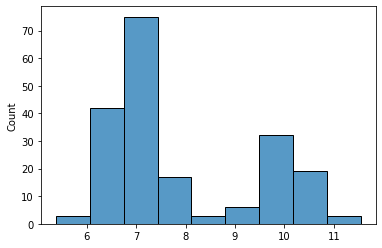

In [2]:
# 1.

rnorm = np.random.normal
rbinom = np.random.binomial

def sample_mixture(gamma, size):
    
    binoms = rbinom(1, gamma, size)

    return binoms * rnorm(7, 0.5, size=size) +\
            (1 - binoms) * (rnorm(10, 0.5, size=size))
initial = sample_mixture(0.7, 200)

avg_initial = np.mean(initial)

sns.histplot(initial);

In [3]:
# 2.

def ABC(n_iterations, n_samples, tol=0.05):
    
    """
    This ABC algorithm compares the distribution averages when
    rejection sampling.
    """
    
    # sample proposed gamma values from uniform distribution
    gamma_vals = np.random.uniform(0, 1, size=n_iterations)
    
    # initialize simulated data averages
    averages = np.empty(n_iterations)
    
    for i in range(n_iterations):
        
        # simulate artificial data
        artificial_data = sample_mixture(gamma_vals[i], n_samples)
        
        # store average
        averages[i] = np.mean(artificial_data)
        
    # filter for gamma values that meet error tolerance
    gamma_post = gamma_vals[np.abs(averages - avg_initial) < tol]
    
    return gamma_post, len(gamma_post)

In [4]:
n_iter = 10000
trace_2, acc = ABC(n_iter, 100, tol=0.4)

Acceptance rate: 0.2594


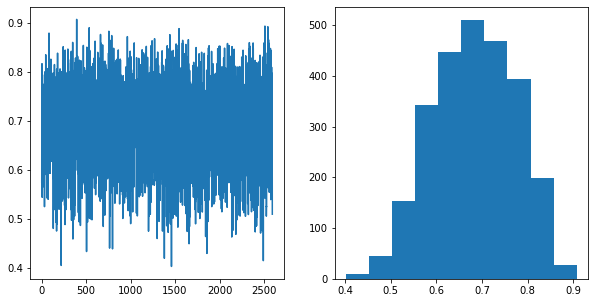

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(trace_2)
axes[1].hist(trace_2)

print('Acceptance rate:', acc/n_iter);


In [6]:
az.summary(trace_2)

arviz - WARNING - Shape validation failed: input_shape: (1, 2594), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.683,0.09,0.529,0.849,0.002,0.001,2513.0,2319.0,NaN


In [7]:
# 3.

from scipy.stats import norm, uniform
dnorm = norm.pdf
duni = uniform.logpdf

def calc_posterior(gam, y=initial, size=200):
    # Calculate joint posterior, given values for gamma

    # Priors on gamma
    logp = duni(gam, 0, 1)

    # Data likelihood
    logp += sum(np.log(gam*dnorm(initial, 7, 0.5**-0.5) +\
                       (1-gam)*dnorm(initial, 10, 0.5**-0.5)))
    
    return logp

runif = np.random.uniform

def metropolis(n_iterations, initial_value):
    
    # Initialize trace for parameters
    trace = np.empty(n_iterations+1)
    
    # Set initial values
    trace[0] = initial_value
        
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(trace[0])
    
    # Initialize acceptance counts
    accepted = 0
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
        p = trace[i].copy()
        
        # Random walk - uniform
        theta = np.abs(p + runif(-1, 1))

        # Calculate log posterior with proposed value
        proposed_log_prob = calc_posterior(theta)

        # Log-acceptance rate
        alpha = proposed_log_prob - current_log_prob

        # Sample a uniform random variate
        u = runif()

        # Test proposed value
        if np.log(u) < alpha:
            # Accept
            trace[i+1] = theta
            current_log_prob = proposed_log_prob
            accepted += 1
        else:
            # Reject
            trace[i+1] = p
            
    return trace, accepted


In [8]:
trace_3, acc = metropolis(n_iter, 0.5)

/var/folders/7_/rt_3qlj97w54brr9cdd1pw9m0000gq/T/ipykernel_81015/2274915095.py:14: RuntimeWarning: invalid value encountered in log
  logp += sum(np.log(gam*dnorm(initial, 7, 0.5**-0.5) +\


Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


Acceptance rate: 0.0664933506649335


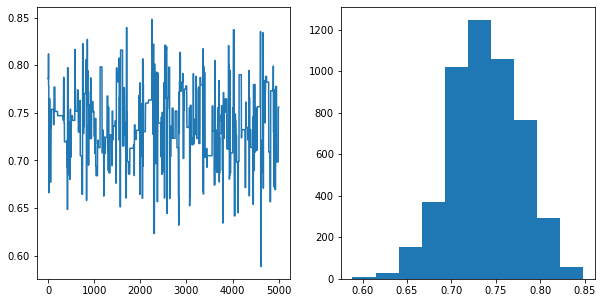

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(trace_3[int(n_iter/2):])
axes[1].hist(trace_3[int(n_iter/2):])

print('Acceptance rate:', acc/len(trace_3))

In [10]:
az.summary(trace_3)

arviz - WARNING - Shape validation failed: input_shape: (1, 10001), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.735,0.04,0.66,0.807,0.002,0.001,462.0,470.0,NaN


In [11]:
# 4.

def metropolis_2(n_iterations, initial_value):
    
    # Initialize trace for parameters
    trace_u = np.empty(n_iterations+1)
    trace_g = np.empty(n_iterations+1)
    
    # Set initial values
    trace_u[0] = initial_value
    trace_g[0] = np.exp(trace_u[0])/(1+np.exp(trace_u[0]))
        
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(trace_g[0])
    
    # Initialize acceptance counts
    accepted = 0
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
        p_u = trace_u[i].copy()
        p_g = trace_g[i].copy()
        
        # Random walk - uniform
        theta_u = np.abs(p_u + runif(-1, 1))
        
        # get gamma from U
        theta_g = np.exp(theta_u)/(1+np.exp(theta_u))

        # Calculate log posterior with proposed value
        proposed_log_prob = calc_posterior(theta_g)

        # Log-acceptance rate
        alpha = proposed_log_prob - current_log_prob

        # Sample a uniform random variate
        u = runif()

        # Test proposed value
        if np.log(u) < alpha:
            # Accept
            trace_u[i+1] = theta_u
            trace_g[i+1] = theta_g
            current_log_prob = proposed_log_prob
            accepted += 1
        else:
            # Reject
            trace_u[i+1] = p_u
            trace_g[i+1] = p_g
            
    return trace_g, trace_u, accepted


In [12]:
trace_4, _, acc = metropolis_2(n_iter, 0.5)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


Acceptance rate: 0.34026597340265974


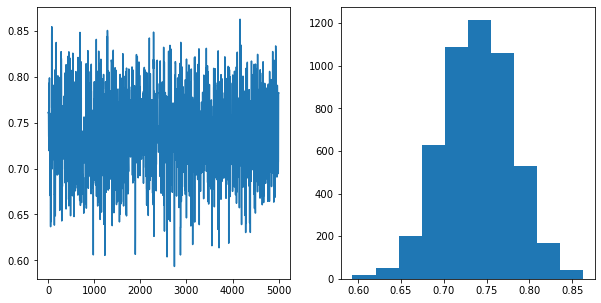

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(trace_4[int(n_iter/2):])
axes[1].hist(trace_4[int(n_iter/2):])

print('Acceptance rate:', acc/len(trace_4))

In [14]:
az.summary(trace_4)

arviz - WARNING - Shape validation failed: input_shape: (1, 10001), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.739,0.042,0.663,0.818,0.001,0.001,2547.0,2601.0,NaN


''

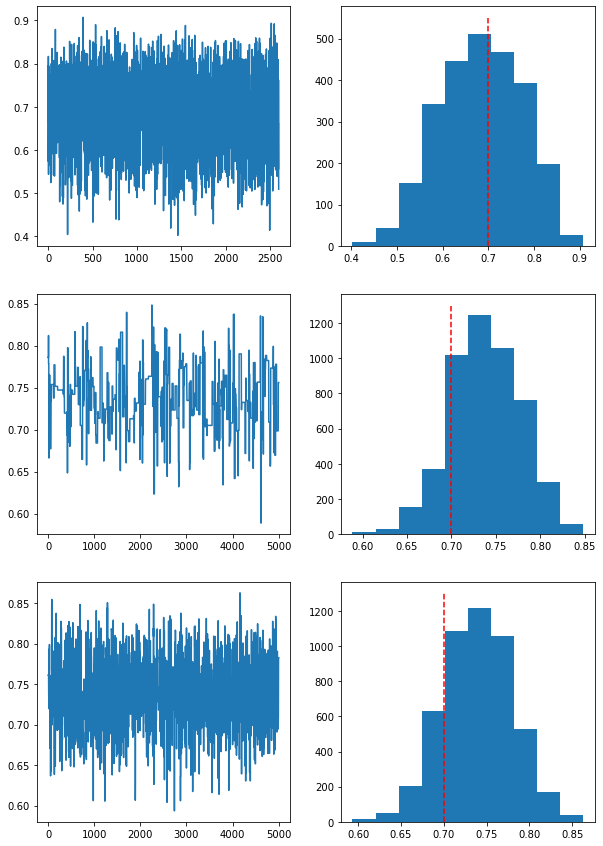

In [15]:
# 5. Comparison

fig, ax = plt.subplots(3, 2, figsize=(10, 15))

burnin = int(n_iter/2)

ax[0,0].plot(trace_2)
ax[0,1].hist(trace_2)
ax[0,1].vlines(0.7, 0, 550, 'red', 'dashed')

ax[1,0].plot(trace_3[burnin:])
ax[1,1].hist(trace_3[burnin:])
ax[1,1].vlines(0.7, 0, 1300, 'red', 'dashed')

ax[2,0].plot(trace_4[burnin:])
ax[2,1].hist(trace_4[burnin:])
ax[2,1].vlines(0.7, 0, 1300, 'red', 'dashed')

;

The third model that reparameterized the random walk and the ABC model appear to have the best convergence behavior as their traces better resemble a fuzzy caterpillar than the second model's. The second model's trace more frequently gets stuck at certain values. Of the three models, the ABC model's point estimate is the closest to the true gamma value, even though its credible interval is skewed more to the right than those of the other models.

ESS IS ALWAYS A GOOD METRIC FOR COMPARING SAMPLING EFFICIENCY

## Question 2

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction. These data are given below.

In one possible random effects model we assume the true baseline mean (on a log-odds scale) $m_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$, and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta \\
\mu_i &\sim \text{Normal}(m, s).
\end{aligned}$$

In this case, we want to make inferences about the population effect $m$, and the predictive distribution for the effect $\delta_{\text{new}}$ in a new trial. 

This particular model uses a random effect for the population mean, and a fixed effect for the treatment effect. There are 3 other models you could fit to represent all possible combinations of fixed or random effects for these two parameters.

Build all 4 models to estimate the treatment effect in PyMC and 

1. use convergence diagnostics to check for convergence in each model 
2. use posterior predictive checks to compare the fit of the models
3. use DIC to compare the models as approximations of the true generating model

Which model would you select and why?

In [16]:
r_t_obs = np.array([3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22])
n_t_obs = np.array([38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680])
r_c_obs = np.array([3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39])
n_c_obs = np.array([39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674])
N = len(n_c_obs)

In [17]:
# Model 1
# random effect for population mean

coords = {'observation': np.arange(N)}
SEED = 1000
with pm.Model(coords=coords, rng_seeder=SEED) as model_1:

    # priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    # fixed treatment effect
    treat = pm.Normal('treat', mu=0., sd=1e5)
    
    # random population effect
    mu = pm.Normal('mu', mu=mu_a, sd=sigma_a, dims='observation')
    
    # control group
    p_c = pm.Deterministic("p_c", pm.math.invlogit(mu))
    
    # treatment group
    p = mu + treat
    p_t = pm.Deterministic("p_t", pm.math.invlogit(p))
    
    
    # likelihood
    pm.Binomial("r_c", n=n_c_obs, p=p_c, observed=r_c_obs)
    pm.Binomial("r_t", n=n_t_obs, p=p_t, observed=r_t_obs)

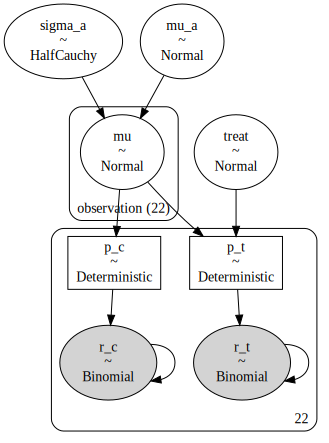

In [18]:
pm.model_to_graphviz(model_1)

In [19]:
with model_1:
    model_1_trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, treat, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


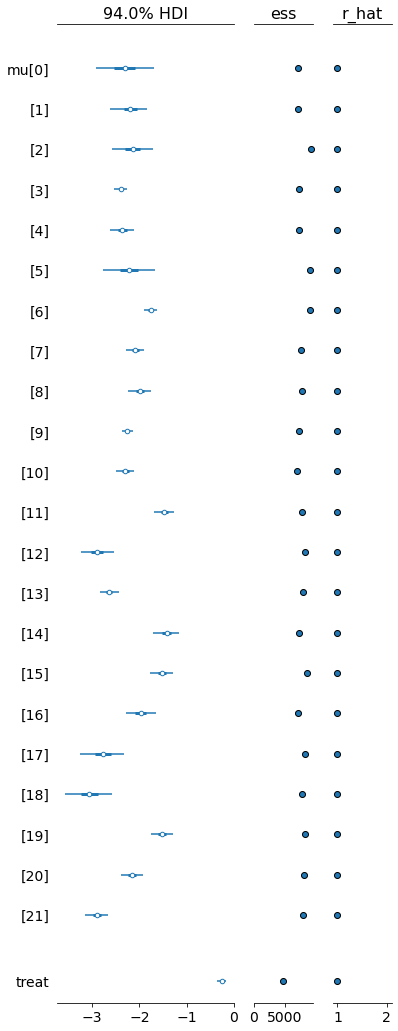

In [20]:
pm.plot_forest(model_1_trace, var_names=['mu', 'treat'],
               figsize=(6,18), combined=True, ess=True, r_hat=True);

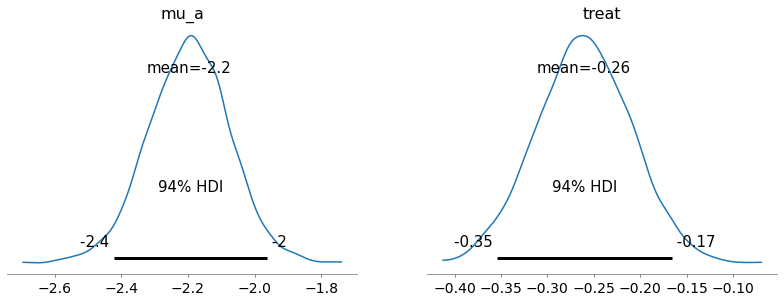

In [21]:
pm.plot_posterior(model_1_trace, var_names=['mu_a', 'treat']);

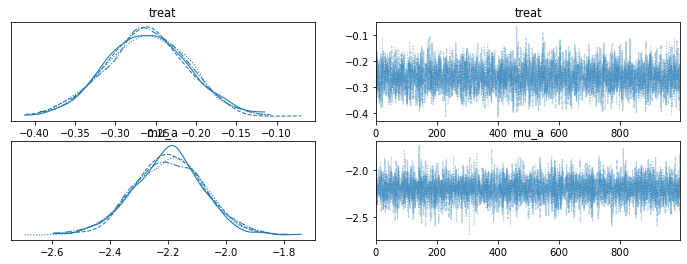

In [22]:
az.plot_trace(model_1_trace, var_names=["treat", "mu_a"]);

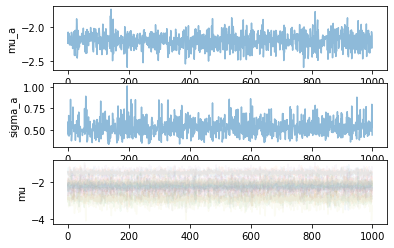

In [23]:
fig, axs = plt.subplots(nrows=3)
axs[0].plot(model_1_trace.posterior.sel(chain=0)['mu_a'], alpha=.5);
axs[0].set(ylabel='mu_a');
axs[1].plot(model_1_trace.posterior.sel(chain=0)['sigma_a'], alpha=.5);
axs[1].set(ylabel='sigma_a');
axs[2].plot(model_1_trace.posterior.sel(chain=0)['mu'], alpha=.05);
axs[2].set(ylabel='mu');

In [24]:
# Model 2
# random effect for treatement effect

with pm.Model(coords=coords, rng_seeder=SEED) as model_2:

    # priors
    mu_b = pm.Normal('mu_b', mu=0., sd=1e5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # random treatment effect
    treat = pm.Normal('treat', mu=mu_b, sd=sigma_b, dims = 'observation')
    
    # fixed population effect
    mu = pm.Normal('mu', mu=0, sd=1e5)
    
    # control group
    p_c = pm.Deterministic("p_c", pm.math.invlogit(mu))
    
    # treatment group
    p = mu + treat
    p_t = pm.Deterministic("p_t", pm.math.invlogit(p))
    
    
    # likelihood
    pm.Binomial("r_c", n=n_c_obs, p=p_c, observed=r_c_obs)
    pm.Binomial("r_t", n=n_t_obs, p=p_t, observed=r_t_obs)

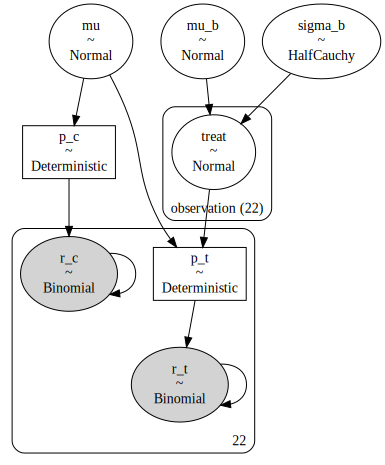

In [25]:
pm.model_to_graphviz(model_2)

In [26]:
with model_2:
    model_2_trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, sigma_b, treat, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


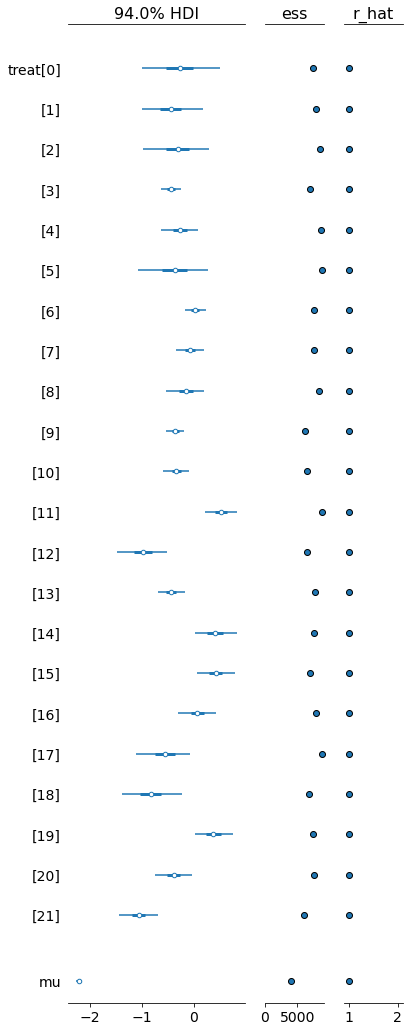

In [27]:
pm.plot_forest(model_2_trace, var_names=['treat', 'mu'],
               figsize=(6,18), combined=True, ess=True, r_hat=True);

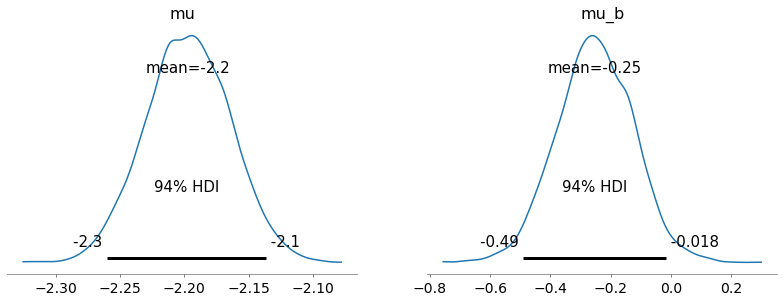

In [28]:
pm.plot_posterior(model_2_trace, var_names=['mu', 'mu_b']);

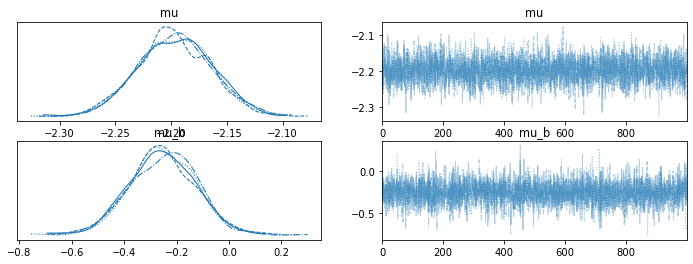

In [29]:
az.plot_trace(model_2_trace, var_names=["mu", "mu_b"]);

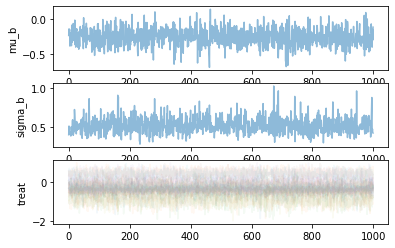

In [30]:
fig, axs = plt.subplots(nrows=3)
axs[0].plot(model_2_trace.posterior.sel(chain=0)['mu_b'], alpha=.5);
axs[0].set(ylabel='mu_b');
axs[1].plot(model_2_trace.posterior.sel(chain=0)['sigma_b'], alpha=.5);
axs[1].set(ylabel='sigma_b');
axs[2].plot(model_2_trace.posterior.sel(chain=0)['treat'], alpha=.05);
axs[2].set(ylabel='treat');

In [31]:
# Model 3
# random effect for population mean and treatment effect.
# the random effects are not centered as previous iterations
# of the model with centered random effects had suboptimal
# convergence behavior (chain got stuck several times)

with pm.Model(coords=coords, rng_seeder=SEED) as model_3:

    # priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    mu_b = pm.Normal('mu_b', mu=0., sd=1e5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # random treatment effect
    z_b = pm.Normal('z_b', mu=0, sd=1, dims='observation')
    treat = pm.Deterministic("treat", mu_b + z_b * sigma_b, dims='observation')
    #treat = pm.Normal('treat', mu=mu_b, sd=sigma_b, dims='observation')
    
    # random population effect
    z_a = pm.Normal('z_a', mu=0, sd=1, dims='observation')
    mu = pm.Deterministic("mu", mu_a + z_a * sigma_a, dims='observation')
    #mu = pm.Normal('mu', mu=mu_a, sd=sigma_a, dims='observation')
    
    # control group
    p_c = pm.Deterministic("p_c", pm.math.invlogit(mu))
    
    # treatment group
    p = mu + treat
    p_t = pm.Deterministic("p_t", pm.math.invlogit(p))
    
    
    # likelihood
    pm.Binomial("r_c", n=n_c_obs, p=p_c, observed=r_c_obs)
    pm.Binomial("r_t", n=n_t_obs, p=p_t, observed=r_t_obs)

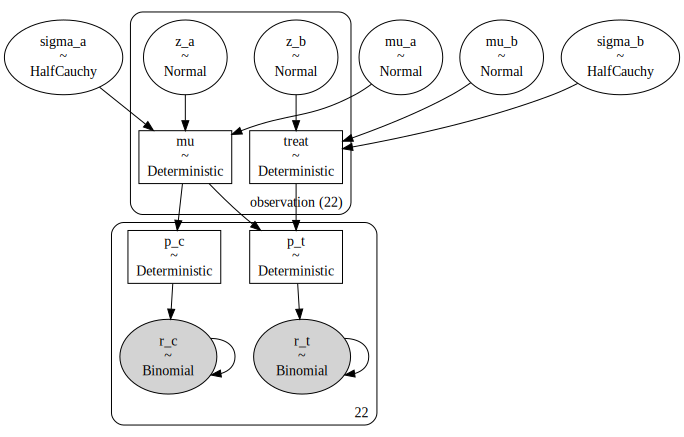

In [32]:
pm.model_to_graphviz(model_3)

In [33]:
with model_3:
    model_3_trace = pm.sample(nuts={'target_accept':0.95})

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, z_b, z_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


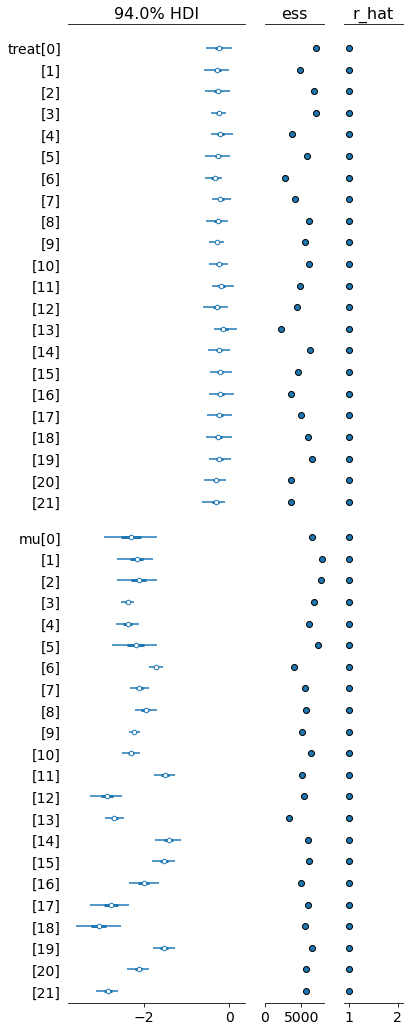

In [34]:
pm.plot_forest(model_3_trace, var_names=['treat', 'mu'],
               figsize=(6,18), combined=True, ess=True, r_hat=True);

<AxesSubplot:>

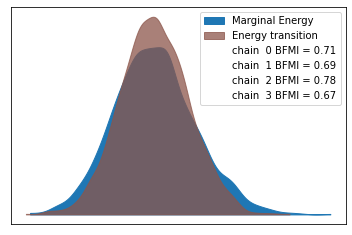

In [35]:
az.plot_energy(model_3_trace)

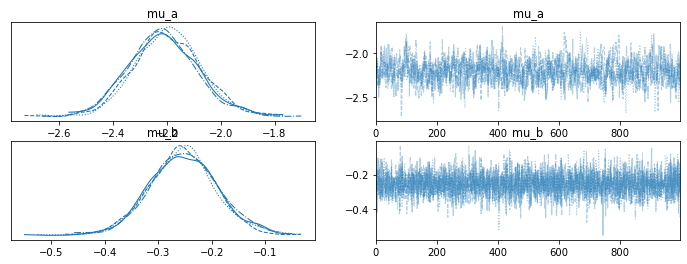

In [36]:
az.plot_trace(model_3_trace, var_names=["mu_a", "mu_b"]);

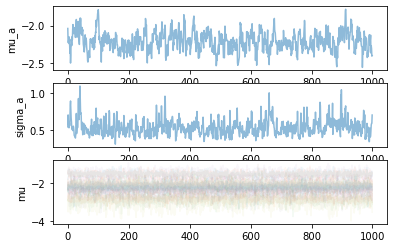

In [37]:
fig, axs = plt.subplots(nrows=3)
axs[0].plot(model_3_trace.posterior.sel(chain=0)['mu_a'], alpha=.5);
axs[0].set(ylabel='mu_a');
axs[1].plot(model_3_trace.posterior.sel(chain=0)['sigma_a'], alpha=.5);
axs[1].set(ylabel='sigma_a');
axs[2].plot(model_3_trace.posterior.sel(chain=0)['mu'], alpha=.05);
axs[2].set(ylabel='mu');

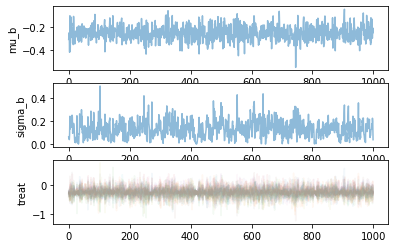

In [38]:
fig, axs = plt.subplots(nrows=3)
axs[0].plot(model_3_trace.posterior.sel(chain=0)['mu_b'], alpha=.5);
axs[0].set(ylabel='mu_b');
axs[1].plot(model_3_trace.posterior.sel(chain=0)['sigma_b'], alpha=.5);
axs[1].set(ylabel='sigma_b');
axs[2].plot(model_3_trace.posterior.sel(chain=0)['treat'], alpha=.05);
axs[2].set(ylabel='treat');

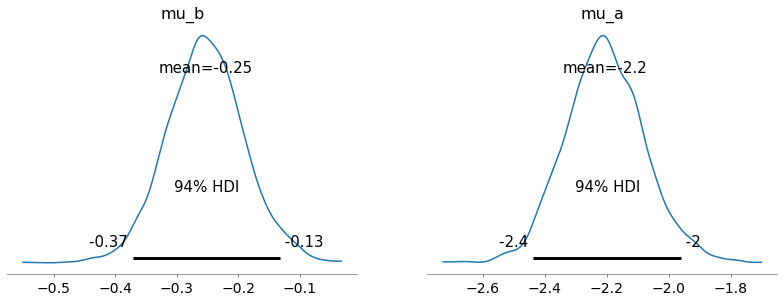

In [39]:
pm.plot_posterior(model_3_trace, var_names=['mu_b', 'mu_a']);

In [40]:
# Model 4
# fixed effect for population mean and treatment

with pm.Model(rng_seeder=SEED) as model_4:
    
    # fixed treatment effect
    treat = pm.Normal('treat', mu=0, sd=1e5)
    
    # fixed population effect
    mu = pm.Normal('mu', mu=0, sd=1e5)
    
    # control group
    p_c = pm.Deterministic("p_c", pm.math.invlogit(mu))
    
    # treatment group
    p = mu + treat
    p_t = pm.Deterministic("p_t", pm.math.invlogit(p))
    
    
    # likelihood
    pm.Binomial("r_c", n=n_c_obs, p=p_c, observed=r_c_obs)
    pm.Binomial("r_t", n=n_t_obs, p=p_t, observed=r_t_obs)

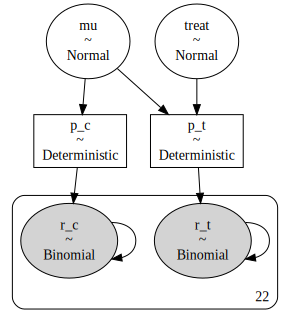

In [41]:
pm.model_to_graphviz(model_4)

In [42]:
with model_4:
    model_4_trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [treat, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


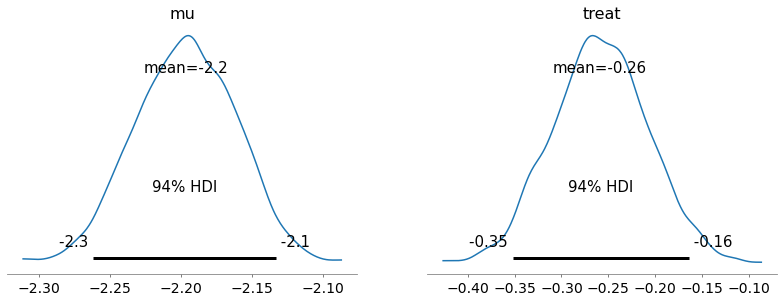

In [43]:
pm.plot_posterior(model_4_trace, var_names=['mu', 'treat']);

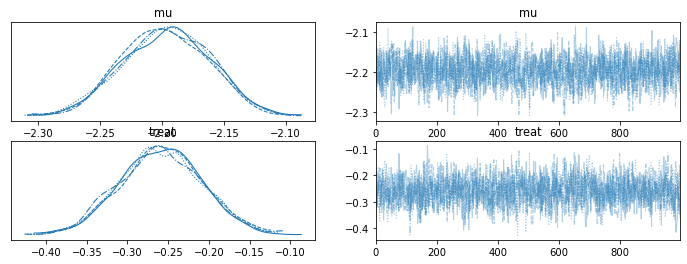

In [44]:
az.plot_trace(model_4_trace, var_names=["mu", "treat"]);

In [45]:
az.summary(model_4_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
treat,-0.259,0.051,-0.352,-0.163,0.001,0.001,1467.0,1802.0,1.0
mu,-2.197,0.035,-2.262,-2.133,0.001,0.001,1502.0,2034.0,1.0
p_c,0.100,0.003,0.094,0.106,0.000,0.000,1502.0,2034.0,1.0
p_t,0.079,0.003,0.074,0.084,0.000,0.000,2635.0,2580.0,1.0


All four models show good convergence behavior.

In [46]:
# combine log likelihood values for r_c and r_t

idata1 = az.convert_to_inference_data(model_1_trace)
idata1.log_likelihood['events'] = idata1.log_likelihood.r_c + idata1.log_likelihood.r_t

idata2 = az.convert_to_inference_data(model_2_trace)
idata2.log_likelihood['events'] = idata2.log_likelihood.r_c + idata2.log_likelihood.r_t

idata3 = az.convert_to_inference_data(model_3_trace)
idata3.log_likelihood['events'] = idata3.log_likelihood.r_c + idata3.log_likelihood.r_t

idata4 = az.convert_to_inference_data(model_4_trace)
idata4.log_likelihood['events'] = idata4.log_likelihood.r_c + idata4.log_likelihood.r_t

In [47]:
df_comp_WAIC_events = az.compare({'random_mu':idata1,
                           'random_treat':idata2,
                           'both_random':idata3,
                           'both_fixed':idata4},
                          ic='waic', var_name='events').round(2)
df_comp_WAIC_events

/usr/local/Caskroom/miniforge/base/envs/bios8366/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/bios8366/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/bios8366/lib/python3.9/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/Caskroom/mi

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
both_random,0,-3114.85,384.05,0.00,1.0,25.00,0.00,True,log
random_mu,1,-3153.82,380.92,38.97,0.0,30.03,7.23,True,log
random_treat,2,-4857.50,440.94,1742.65,0.0,117.09,105.25,True,log
both_fixed,3,-5966.71,346.90,2851.85,0.0,146.85,135.41,True,log


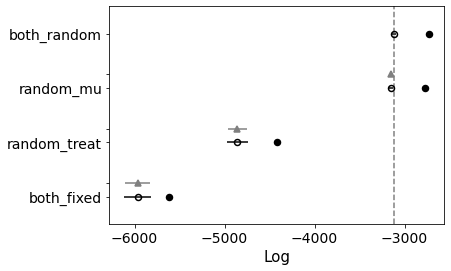

In [48]:
az.plot_compare(df_comp_WAIC_events);

In [49]:
df_comp_LOO_events = az.compare({'random_mu':idata1,
                           'random_treat':idata2,
                           'both_random':idata3,
                           'both_fixed':idata4},
                          ic='loo', var_name='events').round(2)
df_comp_LOO_events

/usr/local/Caskroom/miniforge/base/envs/bios8366/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/bios8366/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/Cas

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
both_random,0,-3235.42,504.61,0.00,0.52,28.80,0.00,True,log
random_mu,1,-3239.30,466.39,3.88,0.48,33.12,7.64,True,log
random_treat,2,-4974.02,557.47,1738.61,0.00,117.03,102.30,True,log
both_fixed,3,-5958.69,338.88,2723.27,0.00,146.07,132.59,True,log


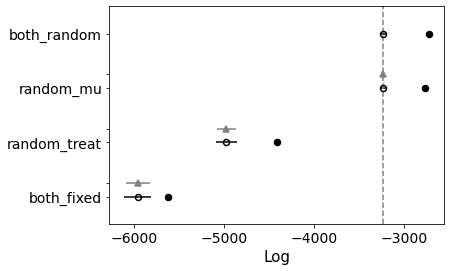

In [50]:
az.plot_compare(df_comp_LOO_events);

The model with non-centered random effects for both the population mean and the treatment effect has the best WAIC and LOO cross-validation scores. The model with a fixed treatment effect and a centered random effect on the population mean came in a close second. Since performance is relatively similar between these two models, I would choose to use the latter a fixed treatment effect is easier to interpret.

50/50